# Introduction to Generative Adversarial Networks (GANs)

Example taken from [Flux Model Zoo DCGAN MNIST](https://github.com/FluxML/model-zoo/blob/master/vision/dcgan_mnist/dcgan_mnist.jl)

Une intro en français [Fidle: 2022/2023 Seq. 13 / Generative Adversarial Networks (GAN)](https://www.youtube.com/watch?v=hvFthCbTl5c)

## Generative models

$$    
\min_{G}\max_{D} \mathrm{Loss}(D, G) = \mathbb{E}_{x\sim z_{\mathrm{data}}}\left[\log D(x)\right]
    +\mathbb{E}_{x\sim f_z}\left[\log \left( 1-D(G(z))\right)\right]
$$

A GAN is a neural network based structure used to generate data that has similar properties to some existing target data set. Most commonly this data set is for images but in this case is a time series. 
The structure is composed of two functions:
1. Generator $G$
- Input: Gaussian noise
- Output: data of the same dimensions as a batch of the target set 
- Goal: the generated data has similar properties to the data set and could be confused with data from this target set. 
2. Discriminator $D$
 - Input: data batch - either generated or from target set
 - Output: probability that this batch belongs to the target data set. 
 - Goal: Distinguish between batches from the target data set (output close to 1) and those that have been generated by the Generator (output close to 0).

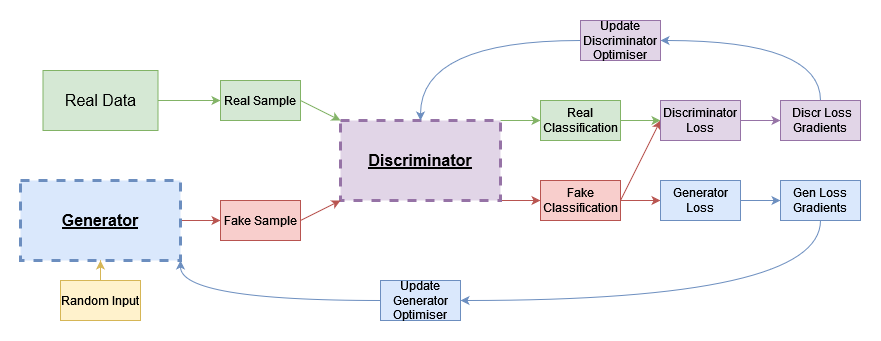

# GAN with Flux

## GAN Packages & Functions

### Packages and functions for Neural Networks

In [1]:
using Base.Iterators: partition
using Flux
using Flux.Optimise: update!
using Flux.Losses: logitbinarycrossentropy
using Flux: params

In [2]:
using Printf # to print

### Hyperparamers

In [3]:
Base.@kwdef struct HyperParams
    batch_size::Int = 128
    latent_dim::Int = 100
    epochs::Int = 200
    verbose_freq::Int = 10
    lr_dscr::Float32 = 0.0002
    lr_gen::Float32 = 0.0002
end

HyperParams

### Discriminator and Generator

In [4]:
# weight initialization as given in the paper https://arxiv.org/abs/1511.06434
dcgan_init(shape...) = randn(Float32, shape...) * 0.02f0

dcgan_init (generic function with 1 method)

In [5]:
function Discriminator()
    return Chain(
            Conv((4, 4), 1 => 64; stride = 2, pad = 1, init = dcgan_init),
            x->leakyrelu.(x, 0.2f0),
            Dropout(0.25),
            Conv((4, 4), 64 => 128; stride = 2, pad = 1, init = dcgan_init),
            x->leakyrelu.(x, 0.2f0),
            Dropout(0.25), 
            x->reshape(x, 7 * 7 * 128, :),
            Dense(7 * 7 * 128, 1))	
end

Discriminator (generic function with 1 method)

In [6]:
function Generator(latent_dim::Int)
    return Chain(
            Dense(latent_dim, 7 * 7 * 256),
            BatchNorm(7 * 7 * 256, relu),
            x->reshape(x, 7, 7, 256, :),
            ConvTranspose((5, 5), 256 => 128; stride = 1, pad = 2, init = dcgan_init),
            BatchNorm(128, relu),
            ConvTranspose((4, 4), 128 => 64; stride = 2, pad = 1, init = dcgan_init),
            BatchNorm(64, relu),
            ConvTranspose((4, 4), 64 => 1; stride = 2, pad = 1, init = dcgan_init),
            x -> tanh.(x)
            )
end

Generator (generic function with 1 method)

### Loss functions

In [7]:
function discriminator_loss(real_output, fake_output)
    real_loss = logitbinarycrossentropy(real_output, 1)
    fake_loss = logitbinarycrossentropy(fake_output, 0)
    return real_loss + fake_loss
end

generator_loss(fake_output) = logitbinarycrossentropy(fake_output, 1)

generator_loss (generic function with 1 method)

### Training functions

In [8]:
function train_discriminator!(gen, dscr, x, opt_dscr, hparams)
    noise = randn!(similar(x, (hparams.latent_dim, hparams.batch_size))) 
    fake_input = gen(noise)
    # Taking gradient
    loss, grads = Flux.withgradient(dscr) do dscr
        discriminator_loss(dscr(x), dscr(fake_input))
    end
    update!(opt_dscr, dscr, grads[1])
    return loss
end

function train_generator!(gen, dscr, x, opt_gen, hparams)
    noise = randn!(similar(x, (hparams.latent_dim, hparams.batch_size))) 
    # Taking gradient
    loss, grads = Flux.withgradient(gen) do gen
        generator_loss(dscr(gen(noise)))
    end
    update!(opt_gen, gen, grads[1])
    return loss
end

train_generator! (generic function with 1 method)

In [9]:
function train(training_X, hparams; output_x = 6, output_y = 6, infos = false)

    device = cpu # if you have GPU `device = gpu`
    # if CUDA.functional()
    #     @info "Training on GPU"
    # else
        @warn "Training on CPU, this will be very slow!"  # 20 mins/epoch
    # end
    N = size(training_X, ndims(training_X))

    # Partition training data into batches
    data = [training_X[:, :, :, r] |> device for r in partition(1:N, hparams.batch_size)]

    # Fixe noise that we will use to vizualize our generator output during the training
    fixed_noise = [randn(Float32, hparams.latent_dim, 1) |> device for _=1:output_x*output_y]
    
    dict_res = Dict() # Where we will store the results

    
    # Discriminator
    dscr = Discriminator() |> device

    # Generator
    gen =  Generator(hparams.latent_dim) |> device

    # Optimizers 
    opt_dscr = Flux.setup(Adam(hparams.lr_dscr), dscr)
    opt_gen = Flux.setup(Adam(hparams.lr_gen), gen)

    # Training
    train_steps = 0
    
    ## To compute the initial loss
    ## Pass the noise to the generator to create a fake imagae
    noise = randn!(similar(training_X, (hparams.latent_dim, N)))
    fake_img = gen(noise)

    # Where we will store the losses
    LOSS_gen = []
    LOSS_disc = []

    for ep in 1:hparams.epochs
        if infos @info "Epoch $ep" end
        for x in data
            train_steps += 1
            # Update discriminator and generator
            loss_dscr = train_discriminator!(gen, dscr, x, opt_dscr, hparams)
            loss_gen = train_generator!(gen, dscr, x, opt_gen, hparams)
            
            if train_steps % hparams.verbose_freq == 0
                push!(LOSS_disc, loss_dscr)
                push!(LOSS_gen, loss_gen)
                if infos @info("Train step $(train_steps), Discriminator loss = $(loss_dscr), Generator loss = $(loss_gen)") end 
                output_image = create_output_image(gen, fixed_noise, output_y)
                save(@sprintf("output/dcgan_steps_%06d.png", train_steps), output_image)
            end
        end
    end

    return gen, dscr, LOSS_gen, LOSS_disc
end

train (generic function with 1 method)

In [10]:
function create_output_image(gen, fixed_noise, output_y)
    fake_images = @. cpu(gen(fixed_noise))
    image_array = reduce(vcat, reduce.(hcat, partition(fake_images, output_y)))
    image_array = permutedims(dropdims(image_array; dims=(3, 4)), (2, 1))
    image_array = @. Gray(image_array + 1f0) / 2f0
    return image_array
end

create_output_image (generic function with 1 method)

## Additional Settings

Packages to generate and plot data

In [11]:
using Statistics
using Random
using MLDatasets
using Images

In [12]:
Random.seed!(1234)

TaskLocalRNG()

## Example 1: A GAN to learn a Normal distribution

### Load MNIST dataset

It should download the dataset the first time you use the function

```{warning}
With no GPU, training the whole 60_000 MNIST dataset can be long (hours)

Try smaller `N` first!
```

In [13]:
images = MLDatasets.MNIST(:train).features

28×28×60000 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  

100-element Vector{Base.ReinterpretArray{Gray{Float32}, 2, Float32, Matrix{Float32}, true}}:
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 ⋮
 [Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); … ; Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0); Gray{Float32}(0.0f0) Gray{Float32}(0.0f0) … Gray{Float32}(0.0f0) Gray{Float32}(0.0f0)]
 [Gray{Flo
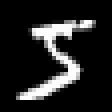
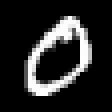
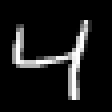
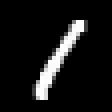
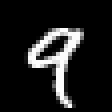
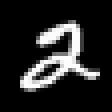
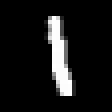
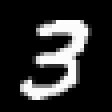
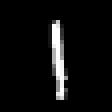
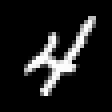
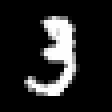
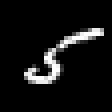
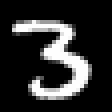
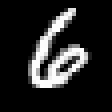
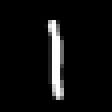
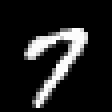
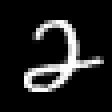
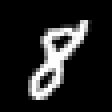
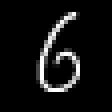
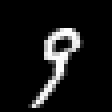
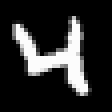
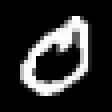
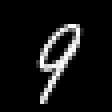
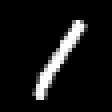
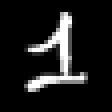
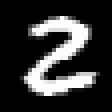
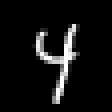
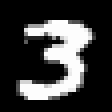
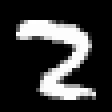
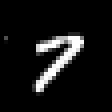
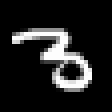
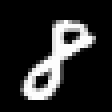
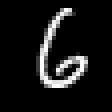
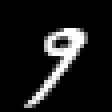
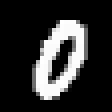
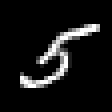
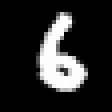
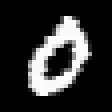
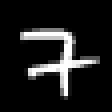
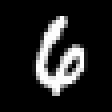
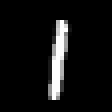
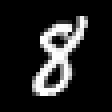
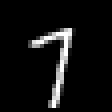
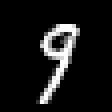
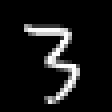
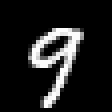
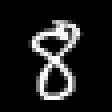
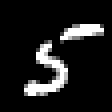
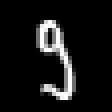
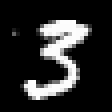
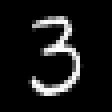
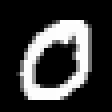
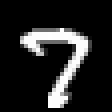
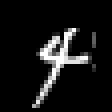
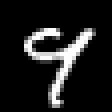
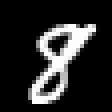
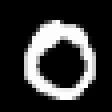
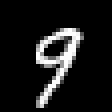
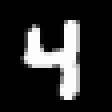
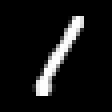
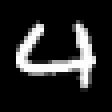
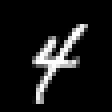
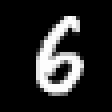
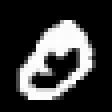
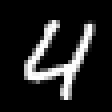
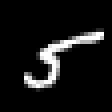
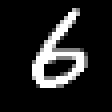
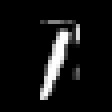
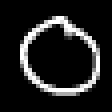
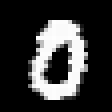
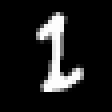
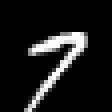
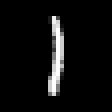
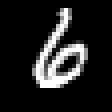
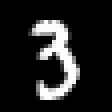
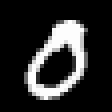
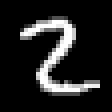
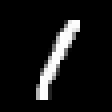
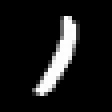
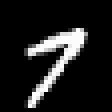
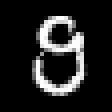
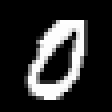
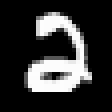
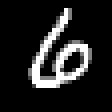
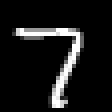
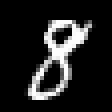
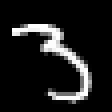
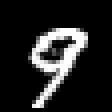
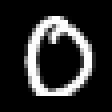
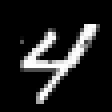
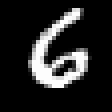
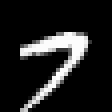
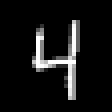
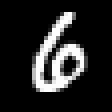
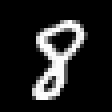
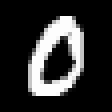
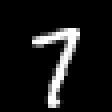
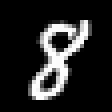
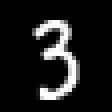
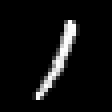

In [14]:
[convert2image(MNIST, images[:,:,i]) for i in 1:100]

Normalize to [-1, 1]

In [15]:
image_tensor = reshape(@.(2f0 * images - 1f0), 28, 28, 1, :)

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0         …  -1.0        -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0            -1.0        -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0            -1.0        -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0            -1.0        -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0             0.0666667  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0         …   0.984314   -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0             0.984314   -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0             0.984314   -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0             0.662745   -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0             0.0588236  -1.0  -1.0  -1.0
  ⋮                             ⋮           ⋱               ⋮          
 -1.0  -1.0  -1.0  -1.0  -1.0  -0.796078       -1.0        -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0   0.301961    

### Training

In [16]:
hparams = HyperParams(epochs = 15, verbose_freq = 50)

HyperParams(128, 100, 15, 50, 0.0002f0, 0.0002f0)

In [17]:
N = 60_000

60000

In [18]:
rm("output", force =true, recursive = true)
@time gen, dscr, lg, ld = train(image_tensor[:,:,:,1:N], hparams, infos = true)

┌ Warning: Training on CPU, this will be very slow!
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:7


┌ Info: Epoch 1
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 50, Discriminator loss = 1.1384606, Generator loss = 0.7350037
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 100, Discriminator loss = 1.4609653, Generator loss = 0.68005073
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 150, Discriminator loss = 0.8577494, Generator loss = 0.89157826
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 200, Discriminator loss = 0.6134143, Generator loss = 1.1532615
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 250, Discriminator loss = 0.8144826, Generator loss = 2.6116474
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 300, Discriminator loss = 0.13746628, Generator loss = 3.5962784
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 350, Discriminator loss = 0.37630245, Generator loss = 3.5455494
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 400, Discriminator loss = 0.09357229, Generator loss = 3.119174
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 450, Discriminator loss = 0.15256013, Generator loss = 3.331066
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 2
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 500, Discriminator loss = 0.032367405, Generator loss = 4.238723
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 550, Discriminator loss = 0.041681804, Generator loss = 4.3481836
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 600, Discriminator loss = 0.032432392, Generator loss = 4.7667437
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 650, Discriminator loss = 0.72190326, Generator loss = 4.6790752
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 700, Discriminator loss = 0.96967185, Generator loss = 2.0859716
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 750, Discriminator loss = 0.17210776, Generator loss = 3.6415827
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 800, Discriminator loss = 0.39549825, Generator loss = 6.0028214
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 850, Discriminator loss = 0.6928412, Generator loss = 1.6879773
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 900, Discriminator loss = 0.44706768, Generator loss = 2.8552282
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 3
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 950, Discriminator loss = 0.5138532, Generator loss = 2.1425638
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1000, Discriminator loss = 0.9098002, Generator loss = 2.1272807
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1050, Discriminator loss = 0.65631866, Generator loss = 2.2181315
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1100, Discriminator loss = 1.1025945, Generator loss = 1.8112569
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1150, Discriminator loss = 0.72294855, Generator loss = 1.869205
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1200, Discriminator loss = 1.044491, Generator loss = 1.108875
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1250, Discriminator loss = 0.74727654, Generator loss = 1.5285889
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1300, Discriminator loss = 1.0148356, Generator loss = 1.413909
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1350, Discriminator loss = 0.6222929, Generator loss = 2.0308716
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1400, Discriminator loss = 0.76294076, Generator loss = 1.9851273
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 4
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 1450, Discriminator loss = 1.1906457, Generator loss = 1.6766274
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1500, Discriminator loss = 1.3949175, Generator loss = 1.0928468
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1550, Discriminator loss = 0.88057005, Generator loss = 1.9004792
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1600, Discriminator loss = 0.84068406, Generator loss = 1.7987137
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1650, Discriminator loss = 0.6534368, Generator loss = 1.739061
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1700, Discriminator loss = 1.5757793, Generator loss = 1.4563825
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1750, Discriminator loss = 0.79181796, Generator loss = 1.501446
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1800, Discriminator loss = 1.0551876, Generator loss = 0.9707648
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1850, Discriminator loss = 1.427703, Generator loss = 1.0651288
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 5
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 1900, Discriminator loss = 0.79847944, Generator loss = 1.62329
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 1950, Discriminator loss = 0.9077008, Generator loss = 1.2181872
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2000, Discriminator loss = 1.0113387, Generator loss = 1.5418504
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2050, Discriminator loss = 1.1201477, Generator loss = 1.2370623
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2100, Discriminator loss = 0.8092724, Generator loss = 1.278044
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2150, Discriminator loss = 1.168741, Generator loss = 1.0781988
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2200, Discriminator loss = 0.9442072, Generator loss = 1.506627
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2250, Discriminator loss = 0.9396812, Generator loss = 1.563607
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2300, Discriminator loss = 0.9837984, Generator loss = 1.2873614
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 6
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 2350, Discriminator loss = 0.7865504, Generator loss = 1.651154
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2400, Discriminator loss = 1.1344602, Generator loss = 1.2058754
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2450, Discriminator loss = 1.0964622, Generator loss = 1.4372898
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2500, Discriminator loss = 1.1704941, Generator loss = 1.4471345
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2550, Discriminator loss = 0.704435, Generator loss = 1.6471813
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2600, Discriminator loss = 0.8963119, Generator loss = 1.7809478
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2650, Discriminator loss = 1.2829046, Generator loss = 1.1520993
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2700, Discriminator loss = 1.0626553, Generator loss = 1.3553843
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2750, Discriminator loss = 1.1134973, Generator loss = 1.3109598
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2800, Discriminator loss = 1.0840807, Generator loss = 1.2113225
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 7
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 2850, Discriminator loss = 0.92075783, Generator loss = 1.3426436
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2900, Discriminator loss = 0.95247483, Generator loss = 1.1681278
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 2950, Discriminator loss = 1.0257485, Generator loss = 1.292806
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3000, Discriminator loss = 0.911258, Generator loss = 1.5377766
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3050, Discriminator loss = 1.284038, Generator loss = 0.98335737
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3100, Discriminator loss = 0.79235744, Generator loss = 1.6472915
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3150, Discriminator loss = 0.96743506, Generator loss = 1.3420063
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3200, Discriminator loss = 1.2745205, Generator loss = 1.3035934
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3250, Discriminator loss = 0.9097187, Generator loss = 1.3218502
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 8
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 3300, Discriminator loss = 1.0202632, Generator loss = 1.2492043
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3350, Discriminator loss = 1.0553998, Generator loss = 1.1454887
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3400, Discriminator loss = 1.0899382, Generator loss = 1.3129424
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3450, Discriminator loss = 0.83911395, Generator loss = 1.3049327
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3500, Discriminator loss = 0.9548894, Generator loss = 1.4529946
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3550, Discriminator loss = 1.0478218, Generator loss = 1.4186662
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3600, Discriminator loss = 1.0640082, Generator loss = 1.3563973
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3650, Discriminator loss = 1.0531284, Generator loss = 1.3116413
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3700, Discriminator loss = 0.97530156, Generator loss = 1.1389523
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3750, Discriminator loss = 0.90937316, Generator loss = 1.4574381
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 9
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 3800, Discriminator loss = 1.3157378, Generator loss = 1.2424158
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3850, Discriminator loss = 0.9722284, Generator loss = 1.3754892
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3900, Discriminator loss = 0.86620605, Generator loss = 1.5217528
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 3950, Discriminator loss = 1.1562508, Generator loss = 1.2758164
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4000, Discriminator loss = 1.1172975, Generator loss = 1.1338365
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4050, Discriminator loss = 0.83261204, Generator loss = 1.3476113
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4100, Discriminator loss = 1.2317313, Generator loss = 1.1194572
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4150, Discriminator loss = 1.2618103, Generator loss = 1.2373236
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4200, Discriminator loss = 1.1579633, Generator loss = 0.9013919
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 10
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 4250, Discriminator loss = 1.0975798, Generator loss = 1.3004209
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4300, Discriminator loss = 1.3344518, Generator loss = 1.2068739
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4350, Discriminator loss = 1.0679336, Generator loss = 1.3205785
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4400, Discriminator loss = 1.2968628, Generator loss = 0.9993133
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4450, Discriminator loss = 1.1337487, Generator loss = 1.1537988
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4500, Discriminator loss = 1.2228789, Generator loss = 1.2034132
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4550, Discriminator loss = 1.3496292, Generator loss = 0.756759
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4600, Discriminator loss = 1.2009251, Generator loss = 1.0556722
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4650, Discriminator loss = 0.86100113, Generator loss = 1.4379218
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 11
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 4700, Discriminator loss = 1.1330634, Generator loss = 1.0307859
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4750, Discriminator loss = 1.1751835, Generator loss = 1.1488136
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4800, Discriminator loss = 1.4420351, Generator loss = 0.68968993
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4850, Discriminator loss = 1.5802317, Generator loss = 1.1331303
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4900, Discriminator loss = 1.3380016, Generator loss = 0.9774902
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 4950, Discriminator loss = 1.6699673, Generator loss = 1.1141237
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5000, Discriminator loss = 1.252956, Generator loss = 1.1939862
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5050, Discriminator loss = 0.8882671, Generator loss = 1.4363341
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5100, Discriminator loss = 0.9401471, Generator loss = 1.0758427
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5150, Discriminator loss = 1.1676965, Generator loss = 0.9490718
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 12
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 5200, Discriminator loss = 1.2977451, Generator loss = 0.8438364
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5250, Discriminator loss = 1.2382689, Generator loss = 0.97756916
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5300, Discriminator loss = 1.1367097, Generator loss = 1.1969146
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5350, Discriminator loss = 0.90418416, Generator loss = 1.1336672
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5400, Discriminator loss = 1.2793882, Generator loss = 0.8485156
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5450, Discriminator loss = 1.9113295, Generator loss = 0.65884936
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5500, Discriminator loss = 1.420418, Generator loss = 1.0509394
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5550, Discriminator loss = 0.9745134, Generator loss = 1.0706689
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5600, Discriminator loss = 1.3055956, Generator loss = 0.8236955
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 13
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 5650, Discriminator loss = 1.462363, Generator loss = 0.7845512
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5700, Discriminator loss = 0.9993205, Generator loss = 0.96112627
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5750, Discriminator loss = 1.161184, Generator loss = 1.0632763
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5800, Discriminator loss = 1.028316, Generator loss = 0.8642518
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5850, Discriminator loss = 2.1818757, Generator loss = 0.61841613
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5900, Discriminator loss = 0.7981906, Generator loss = 1.4892544
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 5950, Discriminator loss = 1.3573925, Generator loss = 0.7568034
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6000, Discriminator loss = 1.4499552, Generator loss = 0.9492464
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6050, Discriminator loss = 1.1183069, Generator loss = 1.0270702
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 14
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 6100, Discriminator loss = 1.218163, Generator loss = 0.8735564
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6150, Discriminator loss = 1.1475487, Generator loss = 1.0888889
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6200, Discriminator loss = 1.2786252, Generator loss = 0.75183344
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6250, Discriminator loss = 1.518187, Generator loss = 0.74892366
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6300, Discriminator loss = 1.4494154, Generator loss = 0.7776733
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6350, Discriminator loss = 1.3139248, Generator loss = 0.8795609
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6400, Discriminator loss = 1.0579464, Generator loss = 0.9978335
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6450, Discriminator loss = 1.4997566, Generator loss = 0.7508252
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6500, Discriminator loss = 1.2718544, Generator loss = 0.85783905
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6550, Discriminator loss = 1.20079, Generator loss = 0.92578626
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Epoch 15
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:43


┌ Info: Train step 6600, Discriminator loss = 1.2027693, Generator loss = 0.9685595
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6650, Discriminator loss = 1.4036533, Generator loss = 0.8394319
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6700, Discriminator loss = 1.2766893, Generator loss = 0.871352
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6750, Discriminator loss = 1.1324761, Generator loss = 0.9747067
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6800, Discriminator loss = 1.1000016, Generator loss = 1.0135715
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6850, Discriminator loss = 1.5125982, Generator loss = 0.72479504
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6900, Discriminator loss = 1.4223096, Generator loss = 0.89591664
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 6950, Discriminator loss = 1.0357573, Generator loss = 1.1635408
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


┌ Info: Train step 7000, Discriminator loss = 1.2847865, Generator loss = 0.8126082
└ @ Main /home/metivierd/work_mistea/David_M/mnist_deep_conv_gan/notebook_6_dcGAN_MNIST.ipynb:53


19891.558399 seconds (120.95 M allocations: 3.449 TiB, 0.70% gc time, 0.31% compilation time: <1% of which was recompilation)


(Chain(Dense(100 => 12544), BatchNorm(12544, relu), #18, ConvTranspose((5, 5), 256 => 128, pad=2), BatchNorm(128, relu), ConvTranspose((4, 4), 128 => 64, pad=1, stride=2), BatchNorm(64, relu), ConvTranspose((4, 4), 64 => 1, pad=1, stride=2), #19), Chain(Conv((4, 4), 1 => 64, pad=1, stride=2), #12, Dropout(0.25), Conv((4, 4), 64 => 128, pad=1, stride=2), #13, Dropout(0.25), #14, Dense(6272 => 1)), Any[0.7350037f0, 0.68005073f0, 0.89157826f0, 1.1532615f0, 2.6116474f0, 3.5962784f0, 3.5455494f0, 3.119174f0, 3.331066f0, 4.238723f0  …  0.92578626f0, 0.9685595f0, 0.8394319f0, 0.871352f0, 0.9747067f0, 1.0135715f0, 0.72479504f0, 0.89591664f0, 1.1635408f0, 0.8126082f0], Any[1.1384606f0, 1.4609653f0, 0.8577494f0, 0.6134143f0, 0.8144826f0, 0.13746628f0, 0.37630245f0, 0.09357229f0, 0.15256013f0, 0.032367405f0  …  1.20079f0, 1.2027693f0, 1.4036533f0, 1.2766893f0, 1.1324761f0, 1.1000016f0, 1.5125982f0, 1.4223096f0, 1.0357573f0, 1.2847865f0])

### Show results

In [19]:
folder = "output"
# Get the image filenames from the folder
img_paths = readdir(folder, join=true)
# Load all the images as an array
images_png = load.(img_paths)
# Join all the images in the array to create a matrix of images
gif_mat = cat(images_png..., dims=3)
save("./mnist_training.gif", gif_mat)

In [20]:
using Plots

┌ Info: Saved animation to /tmp/jl_LGRIXCniXG.gif
└ @ Plots /home/metivierd/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_LGRIXCniXG.gif")
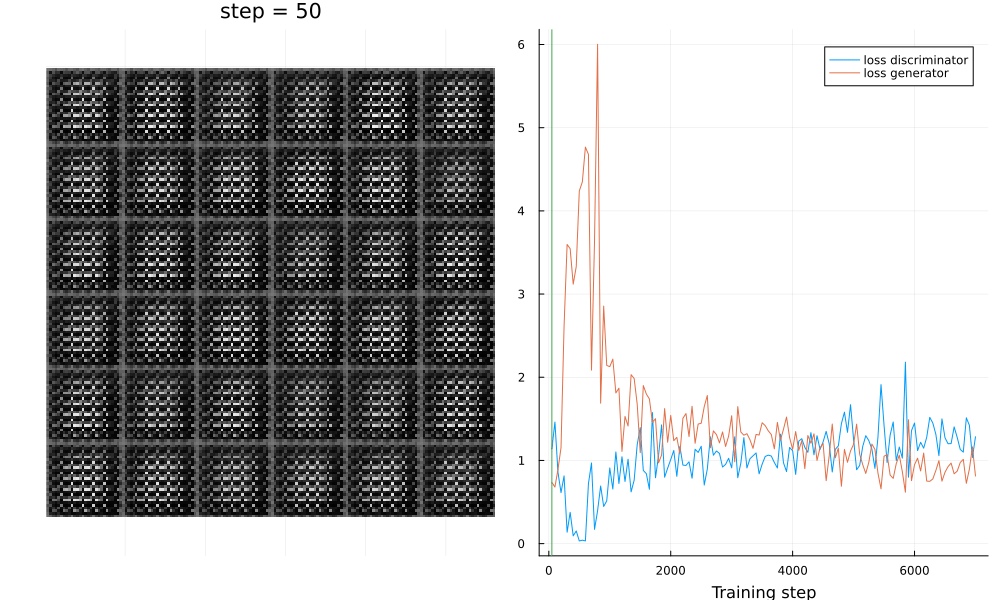

In [23]:
let
    steps = parse.(Int,first.(split.(last.(split.(img_paths, "_")),".")))
    a = @animate for (i, img) in enumerate(images_png)
        p_img = plot(img, showaxis = false)
        title!("step = $(steps[i])")
        ploss = plot(steps, [ld,lg], label = ["loss discriminator" "loss generator"])
        vline!(ploss,[steps[i]], label = :none)
        xlabel!("Training step", legend = :topright)
        plot(p_img, ploss, size = (1000,600))
    end
    gif(a, fps=12)
end